<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
#%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
from utils import process_future_data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/home/gustavo/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [4]:
arrz = process_future_data('data/ARROZ.csv')
bg   = process_future_data('data/BOI_GORDO.csv')
cf   = process_future_data('data/CAFE.csv')
eth  = process_future_data('data/ETANOL.csv')
mil  = process_future_data('data/MILHO.csv')
mf   = process_future_data('data/MINERIO_FERRO.csv')
gold = process_future_data('data/OURO.csv')
petr = process_future_data('data/PETROLEO.csv')
soj  = process_future_data('data/SOJA.csv')
trg  = process_future_data('data/TRIGO.csv')

In [5]:
arrz

date    open    high     low   close   adjcp  volume tic  day
0    2000-01-03   5.180   5.250   5.180   5.230   5.230   486.0  ZR    0
1    2000-01-04   5.250   5.310   5.250   5.270   5.270   836.0  ZR    1
2    2000-01-05   5.250   5.290   5.250   5.290   5.290   700.0  ZR    2
3    2000-01-06   5.320   5.390   5.305   5.360   5.360   478.0  ZR    3
4    2000-01-07   5.300   5.340   5.300   5.340   5.340   714.0  ZR    4
...         ...     ...     ...     ...     ...     ...     ...  ..  ...
5737 2022-10-21  16.815  16.870  16.575  16.680  16.680  2003.0  ZR    4
5738 2022-10-24  16.680  16.775  16.560  16.575  16.575  2512.0  ZR    0
5739 2022-10-25  16.560  16.625  16.530  16.530  16.530  1459.0  ZR    1
5740 2022-10-26  16.545  16.550  16.335  16.370  16.370  1921.0  ZR    2
5741 2022-10-27  16.395  16.455  16.280  16.345  16.345  1630.0  ZR    3

[5742 rows x 9 columns]

In [6]:
cmds_f =pd.concat([arrz,bg,cf,eth,mil,mf,gold,petr,soj,trg],axis=0) 

In [7]:
cmds_f['tic'].unique().tolist()

['ZR', 'LE', 'KC', 'FL', 'ZC', 'TR', 'GC', 'CB', 'ZS', 'ZW']

In [8]:
cmds_f_l = cmds_f['tic'].unique().tolist()
stocks_br  = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'MGLU3.SA', 'BBAS3.SA', 'BBDC4.SA','B3SA3.SA', 'PETR3.SA', 'RENT3.SA', 'ELET3.SA' ]
stocks_usa = ['META', 'AAPL', 'AMZN', 'F', 'T', 'BAC', 'GOOGL', 'MSFT', 'INTC', 'CMCSA']
stocks_eur = ['iSP.MI', 'ENEL.MI', 'SAN.MC', 'INGA.AS', 'ENI.MI', 'BBVA.MC', 'IBE.MC', 'CS.PA', 'STLA.MI','DTE.DE']
stocks_chn = ['601899.SS','600010.SS','600795.SS', '603993.SS', '600157.SS', '601288.SS', '600050.SS', '601398.SS', '600537.SS','600777.SS']

In [9]:
ativos = list(set().union(stocks_br,stocks_usa,stocks_eur,stocks_chn))

In [10]:
len(ativos)

40

In [11]:
#print(config_tickers.DOW_30_TICKER)

In [12]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2004-01-01',
                     end_date = '2022-11-07',
                     ticker_list = ativos, time_interval='1D')
ativos = ativos = list(set().union(stocks_br,stocks_usa,stocks_eur,stocks_chn,cmds_f_l))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
df = pd.concat([df,cmds_f],axis=0)
df['date']= pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [14]:
df.head()

date    open    high     low   close   adjcp    volume tic  day
0 2000-01-03    5.18    5.25    5.18    5.23    5.23     486.0  ZR    0
0 2000-01-03  249.00  251.50  245.25  247.50  247.50   33410.0  ZW    0
0 2000-01-03  461.00  466.00  455.75  456.50  456.50   82180.0  ZS    0
0 2000-01-03  204.50  205.75  200.50  200.75  200.75  128746.0  ZC    0
0 2000-01-03  122.25  124.00  116.10  116.50  116.50    1296.0  KC    0

In [15]:
df['tic'].value_counts()

CB           5860
ZS           5746
ZC           5746
ZW           5746
LE           5743
ZR           5742
GC           5729
KC           5725
INGA.AS      4838
CS.PA        4828
IBE.MC       4828
SAN.MC       4828
BBVA.MC      4810
DTE.DE       4800
iSP.MI       4779
ENI.MI       4778
ENEL.MI      4778
STLA.MI      4773
CMCSA        4745
T            4745
AAPL         4745
AMZN         4745
BAC          4745
F            4745
MSFT         4745
INTC         4745
PETR4.SA     4697
ELET3.SA     4697
VALE3.SA     4697
ITUB4.SA     4697
PETR3.SA     4684
BBAS3.SA     4672
GOOGL        4587
600010.SS    4539
600050.SS    4538
600537.SS    4530
600795.SS    4515
600777.SS    4509
600157.SS    4385
RENT3.SA     4341
601398.SS    3884
FL           3763
B3SA3.SA     3723
BBDC4.SA     3684
601899.SS    3522
601288.SS    2987
MGLU3.SA     2860
TR           2733
META         2635
603993.SS    2449
Name: tic, dtype: int64

In [16]:
df.shape

(228365, 9)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [17]:
dates1= df.query('tic == "META"').date.tolist()
dates2= df.query('tic == "MGLU3.SA"').date.tolist()
dates3= df.query('tic == "STLA.MI"').date.tolist()
dates4= df.query('tic == "601288.SS"').date.tolist()

dates_f1=list(set(dates1).intersection(dates2))
dates_f2=list(set(dates_f1).intersection(dates3))
dates_f3=list(set(dates_f2).intersection(dates4))

print(len(dates1),len(dates2),len(dates3),len(dates4))
print(len(dates_f3))

2635 2860 4773 2987
2349


In [18]:
df.query('tic == "601288.SS"')

date  open  high   low  close     adjcp        volume        tic  \
54226  2010-07-15  2.74  2.74  2.69   2.69  1.433878  4.039725e+09  601288.SS   
54263  2010-07-16  2.70  2.70  2.68   2.69  1.433878  1.378955e+09  601288.SS   
54300  2010-07-19  2.68  2.71  2.68   2.71  1.444538  7.299650e+07  601288.SS   
54337  2010-07-20  2.70  2.71  2.69   2.71  1.444538  8.442261e+08  601288.SS   
54374  2010-07-21  2.70  2.71  2.69   2.71  1.444538  6.220943e+08  601288.SS   
...           ...   ...   ...   ...    ...       ...           ...        ...   
175678 2022-11-01  2.77  2.77  2.71   2.73  2.730000  8.534811e+08  601288.SS   
175718 2022-11-02  2.72  2.73  2.70   2.72  2.720000  5.364922e+08  601288.SS   
175748 2022-11-03  2.72  2.73  2.71   2.72  2.720000  1.874573e+08  601288.SS   
175788 2022-11-04  2.73  2.76  2.72   2.75  2.750000  4.020349e+08  601288.SS   
175828 2022-11-07  2.74  2.75  2.74   2.75  2.750000  2.867223e+08  601288.SS   

        day  
54226     3  
54263     4  
54300     0  
54337     1  
54374     2  
...     ...  
175678    1  
175718    2  
175748    3  
175788    4  
175828    0  

[2987 rows x 9 columns]

In [19]:
print(df.shape)
df=df[df['date'].isin(dates_f3)]
print(df.shape)

(228365, 9)
(117309, 9)


In [20]:
df['day'].value_counts()

2    24733
1    24222
3    23720
4    23564
0    21070
Name: day, dtype: int64

In [21]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [22]:
df.shape

(84564, 17)

In [23]:
df.head()

date      open      high       low     close     adjcp  \
0    2012-05-18  2.250000  2.321428  2.217857  2.235714  2.185609   
2349 2012-05-18  4.150000  4.160000  4.110000  4.120000  3.561568   
4698 2012-05-18  3.753846  3.807692  3.688461  3.711538  3.394421   
7047 2012-05-18  7.045454  7.104545  6.818181  6.859090  6.440304   
9396 2012-05-18  1.234210  1.234210  1.197368  1.207894  1.207894   

           volume        tic  day  macd   boll_ub   boll_lb  rsi_30  \
0     193851534.0  600010.SS    4   0.0  2.304078  2.203064   100.0   
2349   65305612.0  600050.SS    4   0.0  2.304078  2.203064   100.0   
4698   28589158.0  600157.SS    4   0.0  2.304078  2.203064   100.0   
7047   12906528.0  600537.SS    4   0.0  2.304078  2.203064   100.0   
9396   18134458.0  600777.SS    4   0.0  2.304078  2.203064   100.0   

         cci_30  dx_30  close_30_sma  close_60_sma  
0     66.666667  100.0      2.235714      2.235714  
2349  66.666667  100.0      4.120000      4.120000  
4698  66.666667  100.0      3.711538      3.711538  
7047  66.666667  100.0      6.859090      6.859090  
9396  66.666667  100.0      1.207894      1.207894

In [24]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume', 'tic', 'day',
       'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
       'close_30_sma', 'close_60_sma'],
      dtype='object')

## Add covariance matrix as states

In [25]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [26]:
df.shape

(75492, 19)

In [27]:
df.head()

date      open      high       low     close     adjcp       volume  \
0 2013-07-15  1.446428  1.475000  1.432142  1.457142  1.424486  135944326.0   
1 2013-07-15  3.220000  3.280000  3.180000  3.200000  2.827090  103574878.0   
2 2013-07-15  2.396153  2.465384  2.376923  2.423076  2.287073  108237589.0   
3 2013-07-15  4.695454  4.836363  4.604545  4.700000  4.413038   40229182.0   
4 2013-07-15  1.286842  1.315789  1.286842  1.302631  1.302631   11012255.0   

         tic  day      macd   boll_ub   boll_lb     rsi_30      cci_30  \
0  600010.SS    0 -0.055993  1.661526  1.321330  42.151604  -63.271753   
1  600050.SS    0 -0.109234  3.602279  2.873721  41.790241  -45.528445   
2  600157.SS    0 -0.209272  3.068779  1.850835  37.957515  -49.801753   
3  600537.SS    0  0.131110  4.741330  3.798669  57.566372  169.779549   
4  600777.SS    0 -0.034721  1.479910  1.112984  47.440518  -39.380788   

       dx_30  close_30_sma  close_60_sma  \
0   2.660047      1.557023      1.643333   
1  19.020097      3.393667      3.501500   
2  23.508504      2.762948      3.017692   
3  19.139146      4.263787      4.074848   
4   4.597632      1.368596      1.362850   

                                            cov_list  \
0  [[0.0007691357073753004, 0.0001686311654251999...   
1  [[0.0007691357073753004, 0.0001686311654251999...   
2  [[0.0007691357073753004, 0.0001686311654251999...   
3  [[0.0007691357073753004, 0.0001686311654251999...   
4  [[0.0007691357073753004, 0.0001686311654251999...   

                                         return_list  
0  tic         600010.SS  600050.SS  600157.SS  6...  
1  tic         600010.SS  600050.SS  600157.SS  6...  
2  tic         600010.SS  600050.SS  600157.SS  6...  
3  tic         600010.SS  600050.SS  600157.SS  6...  
4  tic         600010.SS  600050.SS  600157.SS  6...

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2009-01-01 to 2020-07-01

In [28]:
train = data_split(df, '2013-07-15','2018-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [29]:
train.head()

date      open      high       low     close     adjcp       volume  \
0 2013-07-15  1.446428  1.475000  1.432142  1.457142  1.424486  135944326.0   
0 2013-07-15  3.220000  3.280000  3.180000  3.200000  2.827090  103574878.0   
0 2013-07-15  2.396153  2.465384  2.376923  2.423076  2.287073  108237589.0   
0 2013-07-15  4.695454  4.836363  4.604545  4.700000  4.413038   40229182.0   
0 2013-07-15  1.286842  1.315789  1.286842  1.302631  1.302631   11012255.0   

         tic  day      macd   boll_ub   boll_lb     rsi_30      cci_30  \
0  600010.SS    0 -0.055993  1.661526  1.321330  42.151604  -63.271753   
0  600050.SS    0 -0.109234  3.602279  2.873721  41.790241  -45.528445   
0  600157.SS    0 -0.209272  3.068779  1.850835  37.957515  -49.801753   
0  600537.SS    0  0.131110  4.741330  3.798669  57.566372  169.779549   
0  600777.SS    0 -0.034721  1.479910  1.112984  47.440518  -39.380788   

       dx_30  close_30_sma  close_60_sma  \
0   2.660047      1.557023      1.643333   
0  19.020097      3.393667      3.501500   
0  23.508504      2.762948      3.017692   
0  19.139146      4.263787      4.074848   
0   4.597632      1.368596      1.362850   

                                            cov_list  \
0  [[0.0007691357073753004, 0.0001686311654251999...   
0  [[0.0007691357073753004, 0.0001686311654251999...   
0  [[0.0007691357073753004, 0.0001686311654251999...   
0  [[0.0007691357073753004, 0.0001686311654251999...   
0  [[0.0007691357073753004, 0.0001686311654251999...   

                                         return_list  
0  tic         600010.SS  600050.SS  600157.SS  6...  
0  tic         600010.SS  600050.SS  600157.SS  6...  
0  tic         600010.SS  600050.SS  600157.SS  6...  
0  tic         600010.SS  600050.SS  600157.SS  6...  
0  tic         600010.SS  600050.SS  600157.SS  6...

## Environment for Portfolio Allocation


In [30]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [31]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 36, State Space: 36


In [32]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [33]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [34]:
state_space

36

In [35]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [36]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# <a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [37]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [38]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [39]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 339       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -51       |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2e+08     |
|    reward             | 1273513.5 |
|    std                | 0.998     |
|    value_loss         | 1.87e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 306       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -51       |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 294       |
|    iterations         | 1300      |
|    time_elapsed       | 22        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -50.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 1299      |
|    policy_loss        | 2.47e+08  |
|    reward             | 1641669.2 |
|    std                | 0.994     |
|    value_loss         | 2.84e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 293       |
|    iterations         | 1400      |
|    time_elapsed       | 23        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -50.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 269       |
|    iterations         | 2500      |
|    time_elapsed       | 46        |
|    total_timesteps    | 12500     |
| train/                |           |
|    entropy_loss       | -50.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 2499      |
|    policy_loss        | 1.94e+08  |
|    reward             | 1270360.9 |
|    std                | 0.991     |
|    value_loss         | 1.79e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 264       |
|    iterations         | 2600      |
|    time_elapsed       | 49        |
|    total_timesteps    | 13000     |
| train/                |           |
|    entropy_loss       | -50.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 266       |
|    iterations         | 3700      |
|    time_elapsed       | 69        |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -50.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 3699      |
|    policy_loss        | 1.86e+08  |
|    reward             | 1252349.6 |
|    std                | 0.988     |
|    value_loss         | 1.6e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 267       |
|    iterations         | 3800      |
|    time_elapsed       | 70        |
|    total_timesteps    | 19000     |
| train/                |           |
|    entropy_loss       | -50.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 270       |
|    iterations         | 4900      |
|    time_elapsed       | 90        |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -50.5     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 4899      |
|    policy_loss        | 1.68e+08  |
|    reward             | 1138289.4 |
|    std                | 0.984     |
|    value_loss         | 1.4e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 270       |
|    iterations         | 5000      |
|    time_elapsed       | 92        |
|    total_timesteps    | 25000     |
| train/                |           |
|    entropy_loss       | -50.5     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 266       |
|    iterations         | 6200      |
|    time_elapsed       | 116       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -50.3     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 6199      |
|    policy_loss        | 2.21e+08  |
|    reward             | 1381087.6 |
|    std                | 0.979     |
|    value_loss         | 2.04e+13  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:2420729.2188235666
Sharpe:  1.4165167207126517
-------------------------------------
| time/                 |           |
|    fps                | 265       |
|    iterations         | 6300      |
|    time_elapsed       | 118       |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -50.3     |

-------------------------------------
| time/                 |           |
|    fps                | 255       |
|    iterations         | 7400      |
|    time_elapsed       | 144       |
|    total_timesteps    | 37000     |
| train/                |           |
|    entropy_loss       | -50.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 7399      |
|    policy_loss        | 2.33e+08  |
|    reward             | 1490137.1 |
|    std                | 0.974     |
|    value_loss         | 2.55e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 254       |
|    iterations         | 7500      |
|    time_elapsed       | 147       |
|    total_timesteps    | 37500     |
| train/                |           |
|    entropy_loss       | -50.1     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 252       |
|    iterations         | 8600      |
|    time_elapsed       | 170       |
|    total_timesteps    | 43000     |
| train/                |           |
|    entropy_loss       | -50       |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 8599      |
|    policy_loss        | 2.1e+08   |
|    reward             | 1400820.0 |
|    std                | 0.97      |
|    value_loss         | 2.26e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 253       |
|    iterations         | 8700      |
|    time_elapsed       | 171       |
|    total_timesteps    | 43500     |
| train/                |           |
|    entropy_loss       | -50       |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 253       |
|    iterations         | 9800      |
|    time_elapsed       | 193       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -49.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 9799      |
|    policy_loss        | 1.92e+08  |
|    reward             | 1253486.9 |
|    std                | 0.969     |
|    value_loss         | 1.73e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 254       |
|    iterations         | 9900      |
|    time_elapsed       | 194       |
|    total_timesteps    | 49500     |
| train/                |           |
|    entropy_loss       | -49.9     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0002    |
|    n_updat

In [40]:
#trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [41]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [42]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

begin_total_asset:1000000
end_total_asset:2350117.7384267827
Sharpe:  1.3718843685070887
begin_total_asset:1000000
end_total_asset:2641902.49587139
Sharpe:  1.5446757563330051
----------------------------------
| time/              |           |
|    fps             | 414       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1041089.9 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2494848.6281160885
Sharpe:  1.4787470948368169
begin_total_asset:1000000
end_total_asset:2598998.722528235
Sharpe:  1.5367124871989297
---------------------------------------
| time/                   |           |
|    fps                  | 369       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fr

begin_total_asset:1000000
end_total_asset:2569127.3594330642
Sharpe:  1.5242435717951084
begin_total_asset:1000000
end_total_asset:2392261.2589697456
Sharpe:  1.4032549117497548
---------------------------------------
| time/                   |           |
|    fps                  | 334       |
|    iterations           | 9         |
|    time_elapsed         | 55        |
|    total_timesteps      | 18432     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -51.1     |
|    explained_variance   | 2.38e-07  |
|    learning_rate        | 0.0001    |
|    loss                 | 3.39e+14  |
|    n_updates            | 80        |
|    policy_gradient_loss | -9.45e-07 |
|    reward               | 1177167.0 |
|    std                  | 1         |
|    value_loss           | 7.42e+14  |
---------------------------------------
begin_total_asset:1000

begin_total_asset:1000000
end_total_asset:2399893.661164937
Sharpe:  1.411688697987484
begin_total_asset:1000000
end_total_asset:2420696.180266271
Sharpe:  1.4170940849248868
---------------------------------------
| time/                   |           |
|    fps                  | 307       |
|    iterations           | 17        |
|    time_elapsed         | 113       |
|    total_timesteps      | 34816     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -51.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 3.24e+14  |
|    n_updates            | 160       |
|    policy_gradient_loss | -1.16e-06 |
|    reward               | 1279639.8 |
|    std                  | 1         |
|    value_loss           | 6.93e+14  |
---------------------------------------
begin_total_asset:1000000

begin_total_asset:1000000
end_total_asset:2422150.5431217463
Sharpe:  1.4312922591880792
begin_total_asset:1000000
end_total_asset:2514324.0542743234
Sharpe:  1.483208867212371
---------------------------------------
| time/                   |           |
|    fps                  | 308       |
|    iterations           | 25        |
|    time_elapsed         | 166       |
|    total_timesteps      | 51200     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -51.1     |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.0001    |
|    loss                 | 3.39e+14  |
|    n_updates            | 240       |
|    policy_gradient_loss | -1.07e-06 |
|    reward               | 1486427.4 |
|    std                  | 1         |
|    value_loss           | 6.8e+14   |
---------------------------------------
begin_total_asset:10000

begin_total_asset:1000000
end_total_asset:2490121.7053060313
Sharpe:  1.4481851160325772
begin_total_asset:1000000
end_total_asset:2424174.6942926603
Sharpe:  1.413454463597443
---------------------------------------
| time/                   |           |
|    fps                  | 310       |
|    iterations           | 33        |
|    time_elapsed         | 217       |
|    total_timesteps      | 67584     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -51.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0001    |
|    loss                 | 3.41e+14  |
|    n_updates            | 320       |
|    policy_gradient_loss | -9.01e-07 |
|    reward               | 1431255.5 |
|    std                  | 1         |
|    value_loss           | 6.81e+14  |
---------------------------------------
begin_total_asset:10000

In [43]:
#trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [44]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [45]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2235790.5021605073
Sharpe:  1.3349382732201058
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 25        |
|    time_elapsed    | 160       |
|    total_timesteps | 4060      |
| train/             |           |
|    actor_loss      | -1.64e+07 |
|    critic_loss     | 3.67e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 3045      |
|    reward          | 2232066.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total

begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
----------------------------------
| time/              |           |
|    episodes        | 36        |
|    fps             | 18        |
|    time_elapsed    | 1996      |
|    total_timesteps | 36540     |
| train/             |           |
|    actor_loss      | -1.17e+08 |
|    critic_loss     | 1.08e+13  |
|    learning_rate   | 0.001     |
|    n_updates       | 35525     |
|    reward          | 2232066.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total_asset:1000000
end_total_asset:2232066.5465242364
Sharpe:  1.3222378122013054
begin_total

In [46]:
#trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [47]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [48]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2301088.4039936136
Sharpe:  1.399024076745364
begin_total_asset:1000000
end_total_asset:2301633.7603862523
Sharpe:  1.399060637297275
begin_total_asset:1000000
end_total_asset:2301632.574711657
Sharpe:  1.3990606970889627
begin_total_asset:1000000
end_total_asset:2301650.348790956
Sharpe:  1.3990736558604557
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 20        |
|    time_elapsed    | 197       |
|    total_timesteps | 4060      |
| train/             |           |
|    actor_loss      | -2.46e+07 |
|    critic_loss     | 1.38e+11  |
|    ent_coef        | 0.361     |
|    ent_coef_loss   | 278       |
|    learning_rate   | 0.0003    |
|    n_updates       | 3959      |
|    reward          | 2301650.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2301637.0721227806
Sharpe:  1.3990616937546727
begin_total_asset:1000000
end_tota

begin_total_asset:1000000
end_total_asset:2308424.8996432503
Sharpe:  1.403653063949777
begin_total_asset:1000000
end_total_asset:2303131.593566387
Sharpe:  1.3997475228101532
begin_total_asset:1000000
end_total_asset:2310498.882532089
Sharpe:  1.404119805922688
----------------------------------
| time/              |           |
|    episodes        | 32        |
|    fps             | 19        |
|    time_elapsed    | 1651      |
|    total_timesteps | 32480     |
| train/             |           |
|    actor_loss      | -1.14e+08 |
|    critic_loss     | 7.75e+12  |
|    ent_coef        | 1.1e+03   |
|    ent_coef_loss   | -315      |
|    learning_rate   | 0.0003    |
|    n_updates       | 32379     |
|    reward          | 2310499.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2300647.043058298
Sharpe:  1.3971577682378127
begin_total_asset:1000000
end_total_asset:2308031.347604742
Sharpe:  1.4032566452594266
begin_total_asset:1000000
end_total_

In [49]:
#trained_sac.save('/content/trained_models/trained_sac.zip')

### Model 5: **TD3**


In [50]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


/home/gustavo/anaconda3/envs/finrl/lib/python3.7/site-packages/stable_baselines3/common/buffers.py:221: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 12.82GB > 11.15GB
  "This system does not have apparently enough memory to store the complete "


In [51]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:2495346.6866144813
Sharpe:  1.4272578960914444
begin_total_asset:1000000
end_total_asset:2722451.104312079
Sharpe:  1.566405162103913
begin_total_asset:1000000
end_total_asset:2722451.104312079
Sharpe:  1.566405162103913
begin_total_asset:1000000
end_total_asset:2722451.104312079
Sharpe:  1.566405162103913
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 29        |
|    time_elapsed    | 135       |
|    total_timesteps | 4060      |
| train/             |           |
|    actor_loss      | -8.85e+06 |
|    critic_loss     | 2.96e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 3045      |
|    reward          | 2722451.0 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2722451.104312079
Sharpe:  1.566405162103913
begin_total_asset:1000000
end_total_asset:2722451.104312079
Sharpe:  1.566405162103913
begin_total_asset:100

In [52]:
#trained_td3.save('/content/trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [53]:
df.tail()

date       open       high        low   close   adjcp  \
75487 2022-11-04  13.244000  13.686000  13.190000  13.564  13.564   
75488 2022-11-04  18.340000  18.410000  18.090000  18.320  18.320   
75489 2022-11-04  85.160000  85.160000  85.160000  85.160  85.160   
75490 2022-11-04  71.150002  73.389999  70.800003  72.250  72.250   
75491 2022-11-04   1.987000   2.073500   1.964000   2.065   2.065   

            volume       tic  day      macd     boll_ub    boll_lb     rsi_30  \
75487   13582104.0   STLA.MI    4  0.133502   14.174327  11.943873  52.220696   
75488   39453000.0         T    4  0.505348   19.545511  13.844490  56.678589   
75489          0.0        TR    4 -4.602129  103.759467  76.642533  37.289939   
75490   61191100.0  VALE3.SA    4  0.017983   75.495532  66.660467  51.750537   
75491  219296454.0    iSP.MI    4  0.056368    2.044222   1.603738  64.466149   

           cci_30      dx_30  close_30_sma  close_60_sma  \
75487   68.252828   1.104657     13.073200     13.559533   
75488  113.205201  39.522128     16.548333     17.229667   
75489  -92.044121  24.466897     92.792667     98.761500   
75490   68.495625  17.429129     70.328999     69.034333   
75491  182.496247  47.946780      1.824200      1.801073   

                                                cov_list  \
75487  [[0.000850896638877668, 0.00010566631249104385...   
75488  [[0.000850896638877668, 0.00010566631249104385...   
75489  [[0.000850896638877668, 0.00010566631249104385...   
75490  [[0.000850896638877668, 0.00010566631249104385...   
75491  [[0.000850896638877668, 0.00010566631249104385...   

                                             return_list  
75487  tic         600010.SS  600050.SS  600157.SS  6...  
75488  tic         600010.SS  600050.SS  600157.SS  6...  
75489  tic         600010.SS  600050.SS  600157.SS  6...  
75490  tic         600010.SS  600050.SS  600157.SS  6...  
75491  tic         600010.SS  600050.SS  600157.SS  6...

In [54]:
trade = data_split(df,'2018-01-02', '2022-11-04')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [55]:
trade.shape

(38916, 19)

In [56]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)
df_daily_return2, df_actions2 = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

df_daily_return3, df_actions3 = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

df_daily_return4, df_actions4 = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1383091.8014430953
Sharpe:  0.4918840135365586
hit end!
begin_total_asset:1000000
end_total_asset:1526871.5285619167
Sharpe:  0.596566056964702
hit end!
begin_total_asset:1000000
end_total_asset:1470331.3827344945
Sharpe:  0.5522956542711415
hit end!
begin_total_asset:1000000
end_total_asset:1475334.0325712012
Sharpe:  0.5640167114021204
hit end!


In [57]:
df_daily_return.head()

date  daily_return
0 2018-01-02      0.000000
1 2018-01-03      0.004930
2 2018-01-04      0.013398
3 2018-01-05      0.007197
4 2018-01-08      0.006230

In [58]:
df_daily_return.to_csv('df_daily_return.csv')

In [59]:
df_actions.head()

600010.SS  600050.SS  600157.SS  600537.SS  600777.SS  600795.SS  \
date                                                                           
2018-01-02   0.027778   0.027778   0.027778   0.027778   0.027778   0.027778   
2018-01-03   0.038744   0.038548   0.015528   0.015431   0.038683   0.015533   
2018-01-04   0.038755   0.038561   0.015515   0.015420   0.038694   0.015520   
2018-01-05   0.038772   0.038588   0.015483   0.015390   0.038742   0.015499   
2018-01-08   0.038795   0.038612   0.015469   0.015376   0.038732   0.015471   

            601288.SS  601398.SS  601899.SS      AAPL  ...  MGLU3.SA  \
date                                                   ...             
2018-01-02   0.027778   0.027778   0.027778  0.027778  ...  0.027778   
2018-01-03   0.038567   0.015488   0.038809  0.015459  ...  0.015487   
2018-01-04   0.038580   0.015476   0.038820  0.015447  ...  0.015475   
2018-01-05   0.038621   0.015446   0.038829  0.015429  ...  0.015445   
2018-01-08   0.038630   0.015430   0.038861  0.015401  ...  0.015428   

                MSFT  PETR3.SA  PETR4.SA  RENT3.SA   STLA.MI         T  \
date                                                                     
2018-01-02  0.027778  0.027778  0.027778  0.027778  0.027778  0.027778   
2018-01-03  0.038774  0.015613  0.015496  0.015567  0.038752  0.015640   
2018-01-04  0.038785  0.015600  0.015484  0.015554  0.038764  0.015627   
2018-01-05  0.038803  0.015565  0.015450  0.015521  0.038776  0.015594   
2018-01-08  0.038826  0.015551  0.015438  0.015508  0.038807  0.015576   

                  TR  VALE3.SA    iSP.MI  
date                                      
2018-01-02  0.027778  0.027778  0.027778  
2018-01-03  0.038920  0.038783  0.038753  
2018-01-04  0.038930  0.038793  0.038764  
2018-01-05  0.038969  0.038832  0.038771  
2018-01-08  0.038965  0.038830  0.038807  

[5 rows x 36 columns]

In [60]:
df_actions.tail()

600010.SS  600050.SS  600157.SS  600537.SS  600777.SS  600795.SS  \
date                                                                           
2022-10-27   0.039007   0.038819   0.015241   0.015169   0.038936   0.015247   
2022-10-28   0.039039   0.038863   0.015204   0.015134   0.038967   0.015208   
2022-10-31   0.039043   0.038876   0.015193   0.015125   0.038974   0.015198   
2022-11-01   0.039040   0.038856   0.015202   0.015135   0.038971   0.015210   
2022-11-03   0.039043   0.038859   0.015196   0.015130   0.038978   0.015206   

            601288.SS  601398.SS  601899.SS      AAPL  ...  MGLU3.SA  \
date                                                   ...             
2022-10-27   0.038851   0.015222   0.039049  0.015187  ...  0.015222   
2022-10-28   0.038893   0.015185   0.039082  0.015150  ...  0.015184   
2022-10-31   0.038904   0.015175   0.039091  0.015140  ...  0.015176   
2022-11-01   0.038890   0.015187   0.039080  0.015151  ...  0.015187   
2022-11-03   0.038894   0.015183   0.039083  0.015148  ...  0.015184   

                MSFT  PETR3.SA  PETR4.SA  RENT3.SA   STLA.MI         T  \
date                                                                     
2022-10-27  0.039012  0.015313  0.015222  0.015273  0.039002  0.015340   
2022-10-28  0.039045  0.015273  0.015184  0.015235  0.039037  0.015299   
2022-10-31  0.039055  0.015262  0.015174  0.015224  0.039049  0.015290   
2022-11-01  0.039044  0.015272  0.015185  0.015233  0.039035  0.015300   
2022-11-03  0.039048  0.015266  0.015181  0.015226  0.039039  0.015296   

                  TR  VALE3.SA    iSP.MI  
date                                      
2022-10-27  0.039135  0.039011  0.039008  
2022-10-28  0.039163  0.039042  0.039042  
2022-10-31  0.039170  0.039049  0.039052  
2022-11-01  0.039163  0.039042  0.039041  
2022-11-03  0.039167  0.039047  0.039044  

[5 rows x 36 columns]

In [61]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [62]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [63]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.078536
Cumulative returns      0.383092
Annual volatility       0.191029
Sharpe ratio            0.491884
Calmar ratio            0.237892
Stability               0.740699
Max drawdown           -0.330136
Omega ratio             1.098174
Sortino ratio           0.677919
Skew                   -0.681077
Kurtosis               16.690388
Tail ratio              0.951618
Daily value at risk    -0.023695
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [64]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1219, 8)
Annual return          0.054899
Cumulative returns     0.295027
Annual volatility      0.219119
Sharpe ratio           0.354340
Calmar ratio           0.148032
Stability              0.675581
Max drawdown          -0.370862
Omega ratio            1.073703
Sortino ratio          0.485837
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.881185
Daily value at risk   -0.027298
dtype: float64


In [65]:
#dp = YahooFinanceProcessor()
#df_comp = dp.download_data(start_date = '2008-01-01',
#                     end_date = '2021-10-31',
#                     ticker_list = ativos, time_interval='1D')
#
#dates1= df_comp.query('tic == "AAPL"').date.tolist()
#dates2= df_comp.query('tic == "PETR3.SA"').date.tolist()
#dates_final=list(set(dates1).intersection(dates2))
#print(len(dates1),len(dates2))
#print(len(dates_final))
#
#print(df_comp.shape)
#df_comp=df_comp[df_comp['date'].isin(dates_final)]
#print(df_comp.shape)
#df_comp = data_split(df_comp,'2020-07-01', '2021-10-31')

In [66]:
#df_comp=df_comp[['date','close','tic']]
df_comp = df[['date','close','tic']].tail(38916)
df_comp.set_index('date',inplace=True)
res = df_comp.pivot(columns='tic', values='close')

# Asset weights
wts = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
      ,0.1,0.1,0.1,0.1,0.1,0.1]


ret_data = res.pct_change()

weighted_returns = (wts * ret_data)
weighted_returns.index= pd.to_datetime(weighted_returns.index)
weighted_returns

tic         600010.SS  600050.SS  600157.SS  600537.SS  600777.SS  600795.SS  \
date                                                                           
2018-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-01-04  -0.000398  -0.000299   0.000000   0.002231   0.002041   0.000317   
2018-01-05   0.000000   0.000749   0.000000  -0.001389  -0.001500   0.000000   
2018-01-08   0.001600   0.001486   0.000000   0.000604   0.000254   0.001266   
2018-01-09   0.000394  -0.000586   0.000000  -0.000800  -0.004304  -0.000937   
...               ...        ...        ...        ...        ...        ...   
2022-10-28  -0.003763  -0.001183  -0.003086  -0.005760  -0.002767  -0.004086   
2022-10-31  -0.001676   0.000599  -0.000637  -0.001868  -0.003659  -0.002018   
2022-11-01   0.003409   0.001488   0.001923   0.006747   0.003797   0.000229   
2022-11-03   0.000000   0.008798  -0.000629   0.000162  -0.000813  -0.001598   
2022-11-04   0.002747  -0.001617   0.002532   0.010032   0.003689   0.003248   

tic         601288.SS  601398.SS  601899.SS      AAPL  ...  MGLU3.SA  \
date                                                   ...             
2018-01-03        NaN        NaN        NaN       NaN  ...       NaN   
2018-01-04  -0.000258  -0.001461   0.001296  0.000464  ...  0.002401   
2018-01-05   0.000000   0.000165  -0.001279  0.001139  ... -0.001971   
2018-01-08  -0.000258  -0.000164   0.004752 -0.000371  ...  0.000013   
2018-01-09  -0.000777   0.000329  -0.000825 -0.000011  ... -0.002404   
...               ...        ...        ...       ...  ...       ...   
2022-10-28   0.000000   0.000000  -0.001580  0.007555  ...  0.003791   
2022-10-31  -0.001429  -0.002353  -0.002222 -0.001541  ...  0.002055   
2022-11-01  -0.001087  -0.001687   0.003535 -0.001754  ...  0.002013   
2022-11-03  -0.000366  -0.000490  -0.000732 -0.007813  ...  0.006798   
2022-11-04   0.001103   0.000739   0.002703 -0.000360  ... -0.000821   

tic             MSFT  PETR3.SA  PETR4.SA  RENT3.SA   STLA.MI         T  \
date                                                                     
2018-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-04  0.000880  0.000855  0.000180  0.001430  0.008360  0.000930   
2018-01-05  0.001240  0.000791  0.000598 -0.001453  0.006350  0.000368   
2018-01-08  0.000102  0.001570  0.001188 -0.000477  0.001060  0.000288   
2018-01-09 -0.000068  0.000000  0.000000 -0.000828  0.001988 -0.001987   
...              ...       ...       ...       ...       ...       ...   
2022-10-28  0.004022 -0.001514 -0.001183  0.000721 -0.000513  0.002496   
2022-10-31 -0.001586 -0.007043 -0.008474  0.005268  0.000708 -0.001353   
2022-11-01 -0.001706  0.000331  0.000168  0.000057  0.000966  0.000658   
2022-11-03 -0.006101  0.000270  0.000301  0.002550 -0.003669 -0.000981   
2022-11-04  0.003333 -0.005230 -0.005509  0.001630  0.002092  0.000826   

tic               TR  VALE3.SA    iSP.MI  
date                                      
2018-01-03       NaN       NaN       NaN  
2018-01-04  0.001607  0.000410  0.002618  
2018-01-05  0.001045  0.001561 -0.000213  
2018-01-08  0.002122  0.002223 -0.000284  
2018-01-09  0.000818 -0.000370  0.001140  
...              ...       ...       ...  
2022-10-28 -0.002469 -0.004879 -0.000031  
2022-10-31 -0.002053 -0.000474  0.001249  
2022-11-01  0.002893  0.003039  0.000840  
2022-11-03  0.004173 -0.002920  0.001254  
2022-11-04  0.002147  0.007595  0.004844  

[1081 rows x 36 columns]

In [67]:
ptf_return= weighted_returns.sum(axis=1,skipna=False)
ptf_return.name= 'Portfolio Returns'
ptf_return.index=DRL_strat.index
ptf_return

date
2018-01-02 00:00:00+00:00         NaN
2018-01-03 00:00:00+00:00    0.040215
2018-01-04 00:00:00+00:00    0.020517
2018-01-05 00:00:00+00:00    0.020019
2018-01-08 00:00:00+00:00   -0.018400
                               ...   
2022-10-27 00:00:00+00:00    0.004417
2022-10-28 00:00:00+00:00   -0.027403
2022-10-31 00:00:00+00:00    0.025646
2022-11-01 00:00:00+00:00   -0.018022
2022-11-03 00:00:00+00:00    0.063427
Name: Portfolio Returns, Length: 1081, dtype: float64

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1220, 8)


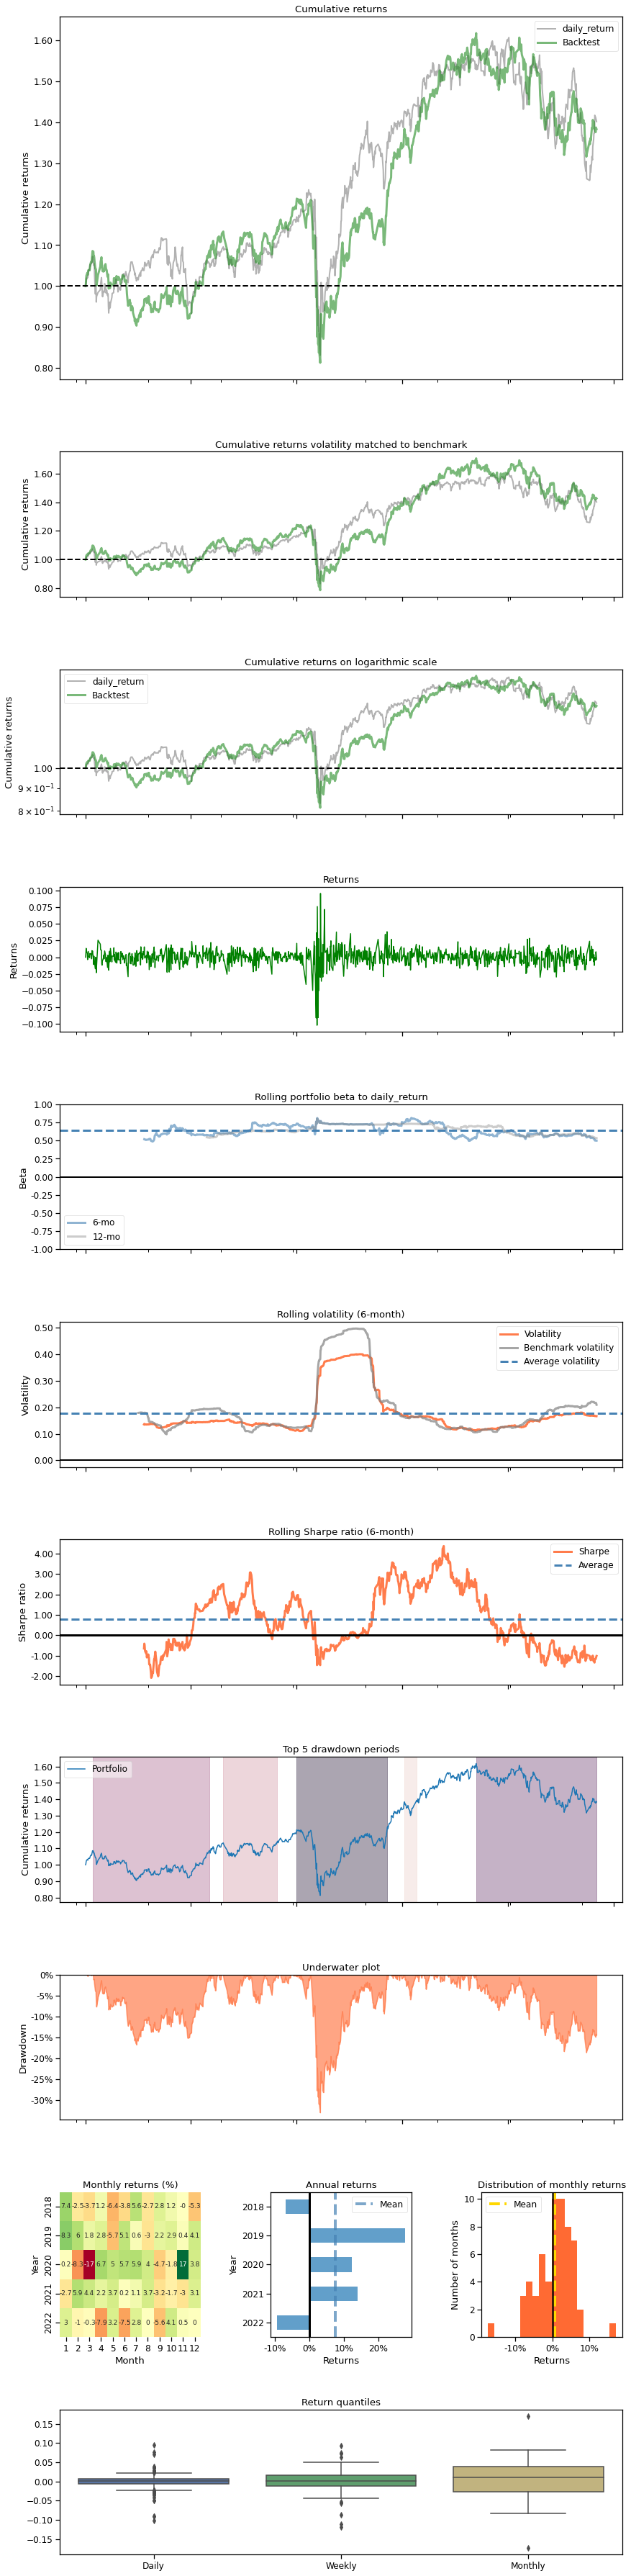

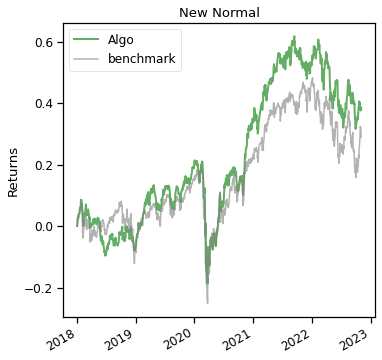

In [68]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2022-11-04'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

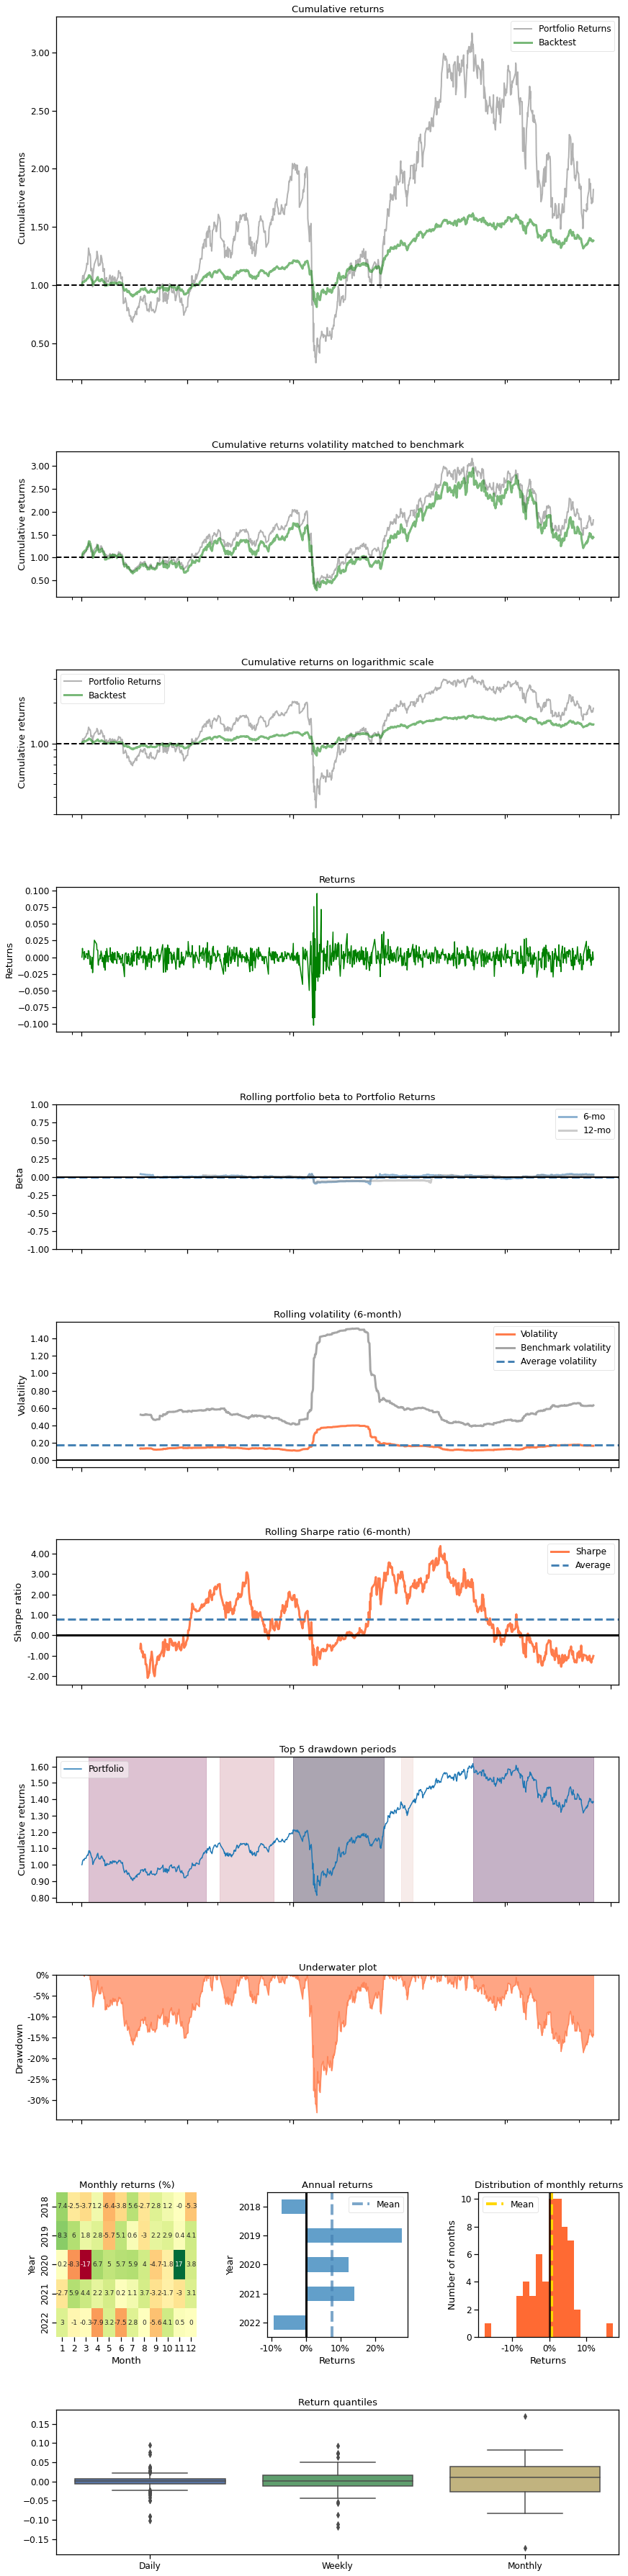

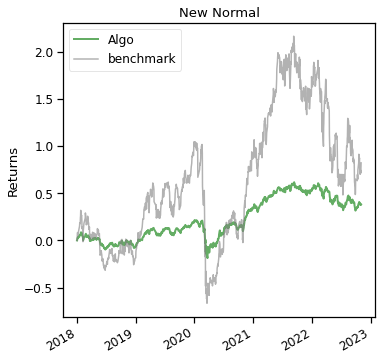

In [69]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=ptf_return, set_context=False)

## Min-Variance Portfolio Allocation

In [70]:
#%pip install PyPortfolioOpt

In [71]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [72]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [73]:
df.head()

date      open      high       low     close     adjcp       volume  \
0 2013-07-15  1.446428  1.475000  1.432142  1.457142  1.424486  135944326.0   
1 2013-07-15  3.220000  3.280000  3.180000  3.200000  2.827090  103574878.0   
2 2013-07-15  2.396153  2.465384  2.376923  2.423076  2.287073  108237589.0   
3 2013-07-15  4.695454  4.836363  4.604545  4.700000  4.413038   40229182.0   
4 2013-07-15  1.286842  1.315789  1.286842  1.302631  1.302631   11012255.0   

         tic  day      macd   boll_ub   boll_lb     rsi_30      cci_30  \
0  600010.SS    0 -0.055993  1.661526  1.321330  42.151604  -63.271753   
1  600050.SS    0 -0.109234  3.602279  2.873721  41.790241  -45.528445   
2  600157.SS    0 -0.209272  3.068779  1.850835  37.957515  -49.801753   
3  600537.SS    0  0.131110  4.741330  3.798669  57.566372  169.779549   
4  600777.SS    0 -0.034721  1.479910  1.112984  47.440518  -39.380788   

       dx_30  close_30_sma  close_60_sma  \
0   2.660047      1.557023      1.643333   
1  19.020097      3.393667      3.501500   
2  23.508504      2.762948      3.017692   
3  19.139146      4.263787      4.074848   
4   4.597632      1.368596      1.362850   

                                            cov_list  \
0  [[0.0007691357073753004, 0.0001686311654251999...   
1  [[0.0007691357073753004, 0.0001686311654251999...   
2  [[0.0007691357073753004, 0.0001686311654251999...   
3  [[0.0007691357073753004, 0.0001686311654251999...   
4  [[0.0007691357073753004, 0.0001686311654251999...   

                                         return_list  
0  tic         600010.SS  600050.SS  600157.SS  6...  
1  tic         600010.SS  600050.SS  600157.SS  6...  
2  tic         600010.SS  600050.SS  600157.SS  6...  
3  tic         600010.SS  600050.SS  600157.SS  6...  
4  tic         600010.SS  600050.SS  600157.SS  6...

In [74]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [75]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
sac_cumpod =(df_daily_return.daily_return+1).cumprod()-1
ddpg_cumpod =(df_daily_return2.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return3.daily_return+1).cumprod()-1
a2c_cumpod =(df_daily_return4.daily_return+1).cumprod()-1


In [76]:
min_var_cumpod =(portfolio.account_value.pct_change().fillna(0)+1).cumprod()-1

In [77]:
dji_cumpod =(baseline_returns.fillna(0)+1).cumprod()-1

In [78]:
ptf_cumpod =(ptf_return.fillna(0)+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [79]:
#%pip install plotly

In [80]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [81]:
time_ind = pd.Series(df_daily_return.date)

In [82]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c


trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
trace3_portfolio = go.Scatter(x = time_ind, y = ptf_cumpod, mode = 'lines', name = 'Portfolio Buy & Hold')
trace4_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
trace5_portfolio = go.Scatter(x = time_ind, y = sac_cumpod, mode = 'lines', name = 'SAC')
trace6_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [83]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)
fig.add_trace(trace6_portfolio)




fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    #paper_bgcolor='rgba(1,1,0,0)',
    #paper_bgcolor='rgb(255,1,0)',
    #plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
#fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
#fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
#fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()